In [9]:

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve, auc
import matplotlib.patches as patches
from sklearn.preprocessing import LabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression



In [10]:
data = pd.read_excel("Source Data 4 The source data for Figure 4 in manuscript.xlsx")


In [11]:
def get_x_y(data, target_variable_name, use_target_features, split=False, stratify = False):
    target = data[target_variable_name]
        
    if use_target_features:
        features = data[data.columns[:21]].drop(target_variable_name, axis=1)
        
    else:
        features = data[data.columns[:18]]
    
    if split:
        scaler = StandardScaler()
        scaler.fit(features)
        features_scaled = scaler.transform(features)
        if stratify:
            train_X, testX, train_Y, testY = train_test_split(features_scaled, target, stratify=target,test_size=0.3,random_state=42)
        else:
            train_X, testX, train_Y, testY = train_test_split(features_scaled, target, test_size=0.3,random_state=42)
        return(train_X, testX, train_Y, testY)

    return features, target

In [12]:
def grid_search(trainX,trainY,id):
    if (id == 'boost'):
        model = make_pipeline(StandardScaler(),OneVsRestClassifier(XGBClassifier()))
        param_grid = {'onevsrestclassifier__estimator__booster':('gbtree', 'gblinear','dart'),'onevsrestclassifier__estimator__max_depth':[5,10,15, None],'onevsrestclassifier__estimator__reg_alpha':np.linspace(0,10,5)}


        print(param_grid)
        print("Optimizing XGB parameters")
        
    elif (id == 'logistic'):
        model = make_pipeline(StandardScaler(),LogisticRegression(penalty='l2',solver='lbfgs',multi_class='ovr',max_iter=3000))    
        param_grid = {'logisticregression__solver':('lbfgs', 'sag', 'saga', 'newton-cg'),'logisticregression__C': np.linspace(0.0001, 5, 10)}

        print(param_grid)
        print("Optimizing logistic regression parameters")
        
    elif (id == 'random'):
        model = make_pipeline(StandardScaler(),RandomForestClassifier(random_state=42))
        param_grid = {'randomforestclassifier__n_estimators': [180, 200,220, 240,260],'randomforestclassifier__max_depth': [5,10,15, None]}


    
    # perform grid search cross-validation to find the optimal regularization parameter
    grid_search = GridSearchCV(model, param_grid, cv=3)
    grid_search.fit(trainX, trainY)
    
    print("Best regularization parameter: ", grid_search.best_params_)
    best_model = grid_search.best_estimator_
    best_model.fit(trainX,trainY)
    return(best_model)

In [13]:
def plot_roc_curves(data, target_variable_name,model,testX,testy,name):
    accuracies = []
    
    X = testX
    y = testy   
    lb = LabelBinarizer()
    lb.fit(y)

    l_one_hot = lb.transform(y)      
    y_score = model.predict_proba(X)
    
    for i in range(10):
        fpr, tpr, _ = roc_curve(l_one_hot[:, i], y_score[:, i])
        auc_score = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"R{i+1} AUC={auc_score:.2f}")
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlabel("False Positive Rate", size=13)
    if (name == 'random'):
        plt.title("ROC curves for random forest")
    elif (name == 'logistic'):
        plt.title("ROC curves for logistic regression")
    elif (name == 'boost'):
        plt.title("ROC curves for XGBoost")
    plt.ylabel("True Positive Rate", size=13)
    plt.legend()
    plt.show()
    
   

def get_cv_accuracies(features, target, n_folds):
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)
    X_un = features.values
    y = target.values
    accuracies = []

    scaler = StandardScaler()
    scaler.fit(X_un)
    X = scaler.transform(X_un)
    
    for train_index, test_index in kf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        clf = RandomForestClassifier(n_estimators=220, random_state=42, max_depth=10)
       # clf = RandomForestClassifier(n_estimators=180, random_state=42, max_depth=5)
        #clf = LogisticRegression(penalty='l2',solver='lbfgs',C=4.444455555555556, multi_class='ovr',max_iter=1000)
      #  clf = LogisticRegression(penalty='l2',solver='lbfgs',C=0.0001, multi_class='ovr',max_iter=3000)
        #clf = XGBClassifier()
        
        model = clf.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracies.append(accuracy_score(y_test, y_pred))
    return accuracies

def get_avg_auc_score(data, target_variable_name, n_folds):
    features, target = get_x_y(data, target_variable_name, use_target_features=False)
    kf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)
    X_un = features.values
    y = target.values
    lb = LabelBinarizer()
    lb.fit(y)
    
    scaler = StandardScaler()
    scaler.fit(X_un)
    X = scaler.transform(X_un)
    auc_scores = []

    for train_index, test_index in kf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        clf = RandomForestClassifier(n_estimators=220, random_state=42, max_depth=10)
        #clf = RandomForestClassifier(n_estimators=180, random_state=42, max_depth=5)
       # clf = LogisticRegression(penalty='l2',solver='lbfgs',C=4.444455555555556, multi_class='ovr',max_iter=1000)
     #   clf = LogisticRegression(penalty='l2',solver='lbfgs',C=0.0001, multi_class='ovr',max_iter=3000)
      #  clf = XGBClassifier()
        
        model = clf.fit(X_train, y_train)
        
        y_score = model.predict_proba(X_test)
        y_test_bin = lb.transform(y_test)
        per_class_auc = []
        for i in range(10):
            fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
            per_class_auc.append(auc(fpr, tpr))
        auc_scores.append(np.mean(per_class_auc))
    return np.mean(auc_scores)
    
def plot_accuracies(data, target_names, n_folds):
    fig, ax = plt.subplots()
    for target_name in target_names:
        features, target = get_x_y(data, target_name, use_target_features=False)
        accuracies = get_cv_accuracies(features, target, n_folds)
        print(accuracies)
        print("sd", np.std(accuracies))
        max_val = np.max(accuracies)
        max_ind = np.argmax(accuracies)
        ax.plot(np.arange(1, n_folds + 1), accuracies, label=target_name)
        if target_name == 'rank-kmeans':
            W = 0.2
            ellipse = patches.Ellipse((max_ind + 1, max_val), width=W, height=0.12 * W, edgecolor='r', facecolor='none')
            ax.add_patch(ellipse)
            ax.text(max_ind + 1.1, max_val, f'{100 * max_val:.2f}%', fontsize=10)
        ax.set_ylim((0.1, 0.9))
        ax.legend()
        print(f'Average Accuracy for {target_name}: {100 * np.mean(accuracies):.2f}%')
    ax.legend()

[0.3472222222222222, 0.3055555555555556, 0.4225352112676056, 0.29577464788732394, 0.4225352112676056, 0.3380281690140845, 0.5070422535211268, 0.5352112676056338, 0.38028169014084506, 0.36619718309859156]
sd 0.07619845356141451
Average Accuracy for rank-kmeans: 39.20%


Text(0.5, 0, 'Round')

<Figure size 432x432 with 0 Axes>

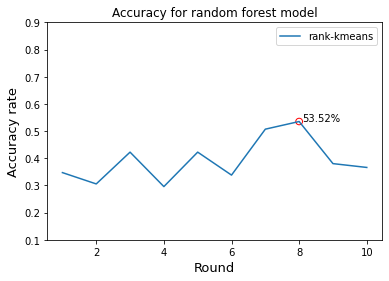

In [14]:
plt.figure(figsize=(6, 6))
plot_accuracies(data, ['rank-kmeans'],n_folds=10)
plt.title("Accuracy for random forest model")
#plt.title("Accuracy for logistic regression model")
#plt.title("Accuracy for XGBoost")
plt.ylabel("Accuracy rate", size=13)
plt.xlabel("Round", size=13)


In [15]:
train_X, testX, train_Y, testY = get_x_y(data, 'rank-kmeans', use_target_features=False,split=True,stratify=False)


In [16]:
name = 'random'
#name = 'logistic'
#name = 'boost'


best_model = grid_search(train_X, train_Y, name)

#clf = XGBClassifier()
#best_model = clf.fit(train_X, train_Y)


Best regularization parameter:  {'randomforestclassifier__max_depth': 10, 'randomforestclassifier__n_estimators': 220}


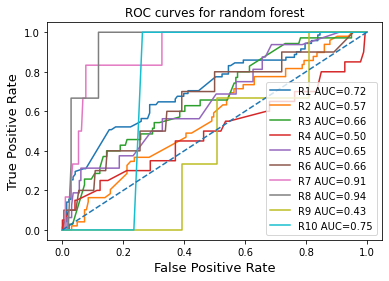

In [17]:
plot_roc_curves(data, 'rank-kmeans',best_model,testX,testY,name)